## Load in Packages

In [66]:
# Import all packages required for practical
# import sys
# !{sys.executable} -m pip install lmfit
import pandas as pd
import numpy as np
import numpy.ma as ma
import julian
import datetime
import math as mt
import scipy
import matplotlib as mpl
import csv
import lmfit
import scipy.integrate as spi
from matplotlib import pyplot as plt 
from matplotlib.colors import LogNorm
from math import nan
import seawater as sw
from holteandtalley import HolteAndTalley
from scipy import interpolate
from scipy import signal
from scipy.io import loadmat
from datetime import timedelta, date
from lmfit import Minimizer, Parameters, report_fit
import matplotlib.ticker as tick
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score 
import scipy.stats as stats
from scipy.stats import pearsonr
import statsmodels.api as sm

In [18]:
# Brewin Model Functions
##Equation 8 of the paper
def fcn2min_1pop(params1, X, Y):
    P1 = params1['P1']
    P2 = params1['P2']
    model = 1 - 1./(1+np.exp(-(P1/P2)*(Y-P2))) 
    return(model-X)
##Equation 7 of the paper
def fcn2min_2pop(params2, X, Y):
    P1 = params2['P1']
    P2 = params2['P2']
    P3 = params2['P3'] 
    P4 = params2['P4'] 
    P5 = params2['P5'] 
    MLD_pop = 1 - 1./(1+np.exp(-(P1/P2)*(Y-P2)))
    DCM_pop = P3*np.exp(-((Y - ((P4+(P5*3.))))/(P5))**2.) 
    #DCM_pop = P3*np.exp(-((Y - P4)/(P5))**2.) 
    model = MLD_pop + DCM_pop
    return(model-X)
#Convert datetime to decimnal year
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

# Read in CTD

In [4]:
#Read CSV from CMAP
filename = 'thousand_m_BATS.csv'
result   = pd.read_csv(filename)
print(len(result))

# Removes rows with NaN fluorescence values(~4000 rows)
result = result.dropna(subset=['fluorescence'], inplace=False)
print(len(result))

# Removes rows with NaN temperature values (~1200 rows)
result = result.dropna(subset=['temperature'], inplace=False)
print(len(result))

# #Removes '0Z' from the end of time column values
result['time'] = result['time'].str[:-2]

# # result.to_csv(r'C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\Scripts\dataset_1001_check_2.csv')


# sort odd profile
print(result[result.cruise_ID == 50047049])
# result[result.cruise_ID == 50047049].sort_values(by='depth')
result.sort_values(by=['time','depth'], inplace=True)

print(result[result.cruise_ID == 50047049])

# result.sort_values(['time'])

1750041
1625939
1624724
                           time        lat        lon       depth  pressure  \
1199414  2012-10-12T14:59:00.00  31.667683 -64.168017   24.824970        25   
1199415  2012-10-12T14:59:00.00  31.667683 -64.168017   26.810777        27   
1199416  2012-10-12T14:59:00.00  31.667683 -64.168017   28.796842        29   
1199417  2012-10-12T14:59:00.00  31.667683 -64.168017   30.782691        31   
1199418  2012-10-12T14:59:00.00  31.667683 -64.168017   32.768352        33   
...                         ...        ...        ...         ...       ...   
1217281  2012-10-12T14:59:00.00  31.667683 -64.168017  995.615361      1005   
1217282  2012-10-12T14:59:00.00  31.667683 -64.168017  997.592247      1007   
1217283  2012-10-12T14:59:00.00  31.667683 -64.168017  999.567999      1009   
1341882  2012-10-12T14:59:00.00  31.667683 -64.168017   20.853350        21   
1341883  2012-10-12T14:59:00.00  31.667683 -64.168017   22.838897        23   

         temperature  condu

### Cruise ID list for CTD

In [5]:
# Extract cruise_ID
ID_list = result['cruise_ID'].values

# Converts to pandas timeseries array
ID_list= pd.Series(ID_list)

# Removes Duplicates
ID_list= pd.unique(ID_list)

len(ID_list)

4659

### Extract Data from CTD

In [6]:
#Read data minos CTD
time          = result.loc[:,'time'].to_numpy()
lat           = result.loc[:,'lat'].to_numpy()
lon           = result.loc[:,'lon'].to_numpy()
depth         = result.loc[:,'depth'].to_numpy()
temperature   = result.loc[:,'temperature'].to_numpy()
TEMP          = result['temperature'][:]
salinity      = result.loc[:,'salinity'].to_numpy()
fluorescence  = result.loc[:,'fluorescence'].to_numpy()
#(Photosynthetically Active Radiation)
PAR           = result.loc[:,'PAR'].to_numpy()
ID            = result.loc[:,'cruise_ID'].to_numpy()

In [7]:
p         = np.where(ID_list == 10019004)
print(p)

(array([47], dtype=int64),)


### Compute MLD for each profile + apply correction

In [15]:
MLD = np.empty(len(ID_list))+nan
fluorescence_NPQ  = fluorescence
MLD_time = []

count = 0
for i in ID_list:
    A = depth[result.cruise_ID == i]
    B = temperature[result.cruise_ID == i]
    C = fluorescence[result.cruise_ID == i]
    if len(A) >= 10:         
        h = HolteAndTalley(A,B)
        
        MLD[count] = h.tempMLD
        # Find .9 of the MLD 
        MLD_9      = MLD[count]#*0.9
        # Find all data above .9 of the MLD 
        AD         = np.where(A <= MLD_9)
        # Ignoring NaNs, find max fluorescence (No stats done on spikes as in Xing)
        D          = np.nanmax(C[AD])
        # Replaces all data above 0.9MLD with the max fluorescence
        C[AD] = D
        # Replacing fluorescence profie with corrected data
        fluorescence_NPQ[result.cruise_ID == i] = C
        multi_date = time[result.cruise_ID == i]
#         MLD_time = np.append(MLD_time, (multi_date[0]), axis=0)
        MLD_time.append(multi_date[0])
    count = count + 1
    
print(MLD)

# plt.plot(MLD)

[ 22.83888949  21.20952463  20.85285035 ... 100.27923704 120.12526401
  89.35806502]


                        time
0     1989-06-22T12:51:07.00
1     1989-06-22T18:49:03.00
2     1989-07-19T17:55:07.00
3     1989-07-20T03:34:51.00
4     1989-07-20T10:00:07.00
...                      ...
4648  2016-12-14T20:29:59.00
4649  2016-12-15T00:19:00.00
4650  2016-12-15T07:53:00.00
4651  2016-12-15T18:03:00.00
4652  2016-12-15T23:45:00.00

[4653 rows x 1 columns]
time    object
dtype: object
4653
datetime64[ns]
4653
4659


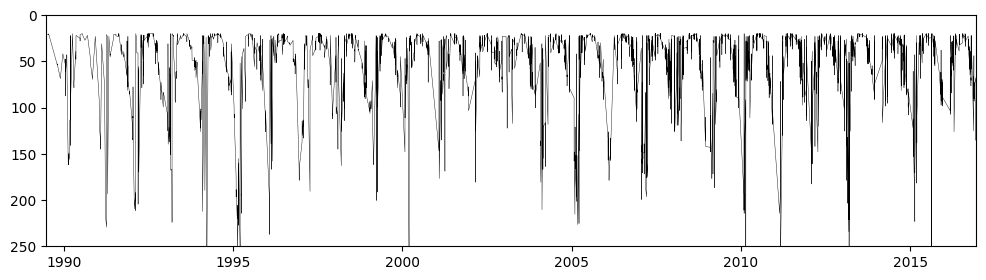

In [86]:
# print(len(MLD[np.where(np.isnan(MLD)==False)]))
# # print(len(np.repeat(MLD,2)))

# print(np.nanmin(MLD))
# print(np.nanmax(MLD))
# q75, q25 = np.nanpercentile(MLD, [75 ,25])
# print(np.nanmean(MLD))
# print(q75, q25)

a = np.isnan(MLD)
MLD_2  = np.delete(MLD, a, 0)
# MLD_time     = np.delete(ts_dates,a, 0)

df_2 = pd.DataFrame(MLD_time,columns=['time'])
  
# printing dataframe 
print(df_2)
  
# checking the type 
print(df_2.dtypes)

df_2=pd.to_datetime(df_2['time'])
print(len(df_2))
print(df_2.dtypes)

#get decimal year
Decimal_year_2 = np.empty(len(MLD_2))+nan
for i in range(len(MLD_2)):
    Decimal_year_2[i] = year_fraction(df_2[i])
    
# plt.scatter(range(len(MLD)),MLD, s=1)
 
fig, (ax1) = plt.subplots(1, sharex=True, figsize=(12,3))
xaxi = [1989.47,2016.95]
ax1.set_ylim([250,0]) 
ax1.set_xlim([xaxi[0],xaxi[-1]])
ax1.plot(Decimal_year_2,MLD_2, color='k', linewidth=0.3)

# plt.savefig("MLD_trans.png", transparent=True)
print(len(MLD_time))
print(len(MLD))
# plt.scatter(MLD_time,MLD, s=1)

# multi_date = time[result.cruise_ID == 50047049]
# print(multi_date[0])
# print(count)
# print(type(multi_date))

# print(len(Decimal_year_2))

# Read in Bottle Data

In [20]:
#Read CSV from CMAP
bottle   = pd.read_csv('BATS_pigment.csv')
print(len(bottle))
# # Removes rows with NaN combined chlA values
# bottle = bottle.dropna(subset=['pigment16'], inplace=False)
# print(len(bottle))

#Removes '0Z' from the end of time column values
bottle['time'] = bottle['time'].str[:-2]

# Removes last 2 digits from ID to make all results in profile the same ID
bottle['Cruise_ID'] = bottle['Cruise_ID'].astype(str).str[:-2].astype(np.int64)


4896


### Extract Data from Bottle

In [21]:
b_pig14         = bottle.loc[:,'pigment14'].to_numpy()
b_pig14         = b_pig14/1000
bottle['pigment14'] = b_pig14

# create combined chl A data
bot22 = [bottle['pigment14'], bottle['pigment16']]
print(len(bot22[0]))
bot22 = np.nanmean(bot22, axis = 0)
bottle['pigment22'] = bot22

# Removes rows with NaN combined chlA values
bottle = bottle.dropna(subset=['pigment22'], inplace=False)
print(len(bottle))

# sort by time
bottle = bottle.sort_values(['time'])

#Read in bottle data
b_time          = bottle.loc[:,'time'].to_numpy()
b_depth         = bottle.loc[:,'depth'].to_numpy()
b_pig16         = bottle.loc[:,'pigment16'].to_numpy()
b_pig14         = bottle.loc[:,'pigment14'].to_numpy()



b_pig22       = bottle.loc[:,'pigment22'].to_numpy()
ID2             = bottle.loc[:,'Cruise_ID'].to_numpy()

4896
4896


### Cruise ID list for Bottle

In [22]:
# Extract cruise_ID
ID_list_b = bottle['Cruise_ID'].values

# Converts to pandas timeseries array
ID_list_b= pd.Series(ID_list_b)

# Removes Duplicates
ID_list_b= pd.unique(ID_list_b)

len(ID_list_b)

454

# Fluorescence Calibration

In [23]:
# print(result[CTD_loc[101]]['depth'])
# len(ID_list_b)
# print(result)
bot_prof = bottle[bottle['Cruise_ID'] == ID_list_b[101]]
print(bot_prof)
# print(bottle['pigment22'].isnull().sum())
# print(np.count_nonzero(bottle['pigment22']==0))

                        time     lat     lon  depth  pigment1  pigment2  \
1152  1995-04-27T00:00:00.00  31.719 -64.203  250.1       0.0       0.0   
1151  1995-04-27T00:00:00.00  31.719 -64.203  201.1       0.0       0.0   
1150  1995-04-27T00:00:00.00  31.719 -64.203  160.0       0.0       0.0   
1149  1995-04-27T00:00:00.00  31.719 -64.203  140.2       0.0       0.0   
1148  1995-04-27T00:00:00.00  31.719 -64.203  120.9       1.0       0.0   
1147  1995-04-27T00:00:00.00  31.719 -64.203  100.9       3.0       0.0   
1146  1995-04-27T00:00:00.00  31.719 -64.203   82.2       7.0       0.0   
1145  1995-04-27T00:00:00.00  31.719 -64.203   60.8       1.0       0.0   
1144  1995-04-27T00:00:00.00  31.719 -64.203   40.6       0.0       0.0   
1143  1995-04-27T00:00:00.00  31.719 -64.203   22.5       0.0       0.0   
1142  1995-04-27T00:00:00.00  31.719 -64.203   11.4       0.0       0.0   
1141  1995-04-27T00:00:00.00  31.719 -64.203    2.4       0.0       0.0   

      pigment3  pigment4

In [24]:
ID_1 = 10330011  # bottle id
x = np.where(result.cruise_ID == ID_1)
# print(x)

# Loop for CTD location array
count = 0
# list to store, corresponding results positions for profile
CTD_loc = []
for i in ID_list_b:
    # i = bottle id
#     CTD_loc = np.where(result.cruise_ID == i)
    CTD_loc.append(result['cruise_ID'] == i)
    count = count + 1

# Arrays are the same length
print(len(ID_list_b))
print(len(CTD_loc))

## Gives Bottle Cruise_ID profile from CTD
print(result[CTD_loc[101]])
print(bottle[bottle['Cruise_ID'] == ID_list_b[101]])

print(b_pig22[2809])
# 2809

454
454
                          time     lat     lon       depth  pressure  \
221481  1995-04-27T12:47:47.00  31.719 -64.203   19.860178        20   
221482  1995-04-27T12:47:47.00  31.719 -64.203   21.846090        22   
221483  1995-04-27T12:47:47.00  31.719 -64.203   23.831982        24   
221484  1995-04-27T12:47:47.00  31.719 -64.203   25.817855        26   
221485  1995-04-27T12:47:47.00  31.719 -64.203   27.803709        28   
...                        ...     ...     ...         ...       ...   
226696  1995-04-27T12:47:47.00  31.719 -64.203  501.872723       506   
226697  1995-04-27T12:47:47.00  31.719 -64.203  503.853985       508   
226698  1995-04-27T12:47:47.00  31.719 -64.203  505.835228       510   
226699  1995-04-27T12:47:47.00  31.719 -64.203  507.816453       512   
226700  1995-04-27T12:47:47.00  31.719 -64.203  509.797658       514   

        temperature  conductivity  salinity  dissolved_oxygen  \
221481      20.4995      5.064128   36.7969           224.084 

### Example Profile

(array([4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883,
       4884], dtype=int64),)


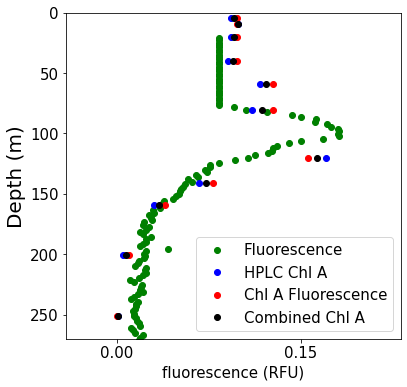

In [25]:
AS = np.where(bottle.Cruise_ID == ID_1) #ID_1
print(AS)
depth_1        = depth[x]
temperature_1  = temperature[x]
fluorescence_1 = fluorescence_NPQ[x]
b_pig16_1      = b_pig16[AS]
b_pig14_1      = b_pig14[AS]
b_pig22_1      = b_pig22[AS]
b_depth_1      = b_depth[AS]

#Plot optical depth
XSIZE = 6 #Define the xsize of the figure window
YSIZE = 6 #Define the ysize of the figure window

#Define the figure window including 5 subplots orientated horizontally
fig, (ax3) = plt.subplots(1, sharey=True, figsize=(XSIZE,YSIZE), \
gridspec_kw={'hspace': 0})

ax3.plot(fluorescence_1,depth_1, \
         color = 'g', marker = 'o', linestyle = 'None', label= 'Fluorescence')
ax3.plot(b_pig14_1,b_depth_1, \
         color = 'b', marker = 'o', linestyle = 'None', label= 'HPLC Chl A')
ax3.plot(b_pig16_1,b_depth_1, \
         color = 'r', marker = 'o', linestyle = 'None', label= 'Chl A Fluorescence')
ax3.plot(b_pig22_1,b_depth_1, \
         color = 'k', marker = 'o', linestyle = 'None', label= 'Combined Chl A')
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.set_ylim([270,0]) 
ax3.set_xlabel('fluorescence (RFU)', fontsize=15, color = 'k')
ax3.xaxis.set_tick_params(labelsize=15)
ax3.set_xlim(xmin=np.min(fluorescence_1)-0.05, xmax=np.max(fluorescence_1)+0.05)
ax3.legend(loc="lower right", fontsize=15)
ax3.xaxis.set_major_locator(plt.MaxNLocator(2))

#Complete the plot
plt.show()

### Time-Series of CTD+Bottle Profiles

In [26]:
# Create 2d time-series array, with correct x-shape
CALI_Prof_series = np.array([[np.nan,np.nan,np.nan,np.nan,np.nan], [np.nan,np.nan,np.nan,np.nan,np.nan]])
# loop which selects each Bottle Profile

for p in list(range(0,np.size(ID_list_b))):
    CTD_Prof    = result[CTD_loc[p]]
    BOTTLE_Prof = bottle[bottle['Cruise_ID'] == ID_list_b[p]]
        
    # Create Dataframe for Calibration Profile
    CALI_Prof   = BOTTLE_Prof[['time','depth','pigment22']]
    CALI_Prof['abs_diff'], CALI_Prof['fluorescence'] = [np.nan, np.nan]
    CALI_Prof.reset_index(drop = True, inplace = True)

    for j in list(range(0,len(CALI_Prof))):
        Bot_depth = BOTTLE_Prof.iloc[j,3] # Find depth of bottle measurement being used
        minimum_abs_dif = 3                       # Set minimum acceptible difference
        abs_dif         = minimum_abs_dif         # Set minimum acceptible difference
        measurement = 0
        # Loop through every CTD measurement in profile {(i = row in CTD profile)}
        for i in list(range(0,len(CTD_Prof))):

            # If difference in depth is <3 / < prev measure in loop, select it
            if abs(CTD_Prof.iat[i, 3]-Bot_depth) < abs_dif:
                # Sets new absolute difference
                abs_dif = abs(CTD_Prof.iat[i, 3]-Bot_depth)
                # Save/overwrite fluorescence measurement
                flu_meas = CTD_Prof.iloc[i, -3]

        # If measurement has been found
        if abs_dif != 3:
            #add Fluorescence/abs_dif to calibration array
            CALI_Prof.loc[j, ['fluorescence']]     = flu_meas
            CALI_Prof.loc[j, ['abs_diff']]         = abs_dif
    
    # Add Calibration Profile to the bottom Calibration Profile Time-Series
    CALI_Prof_series = np.append(CALI_Prof_series, CALI_Prof, axis=0)

nanidx           = np.where(CALI_Prof_series[:,4]==0)
CALI_Prof_series = np.delete(CALI_Prof_series, nanidx, 0)
# CALI_Prof_series.dropna(subset=[4], inplace=False)
# bottle = bottle.dropna(subset=['pigment22'], inplace=False)

# After CALI_Prof_series is created, make new column for difference in BOTTLE chlA and CTD fluorescence
difference_column = np.array([(CALI_Prof_series[:,2] / CALI_Prof_series[:,4])])
# # Try reletive difference
# difference_column = np.array([(CALI_Prof_series[:,2] / CALI_Prof_series[:,4])])
# Append new column
CALI_Prof_series = np.append(CALI_Prof_series,difference_column.T, axis = 1)

### CALI_Prof_series FORMAT:
### ['time','depth','pigment22','depth_difference','fluorescence','chla/flu_difference']

C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/3342076186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CALI_Prof['abs_diff'], CALI_Prof['fluorescence'] = [np.nan, np.nan]
C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [27]:
print(CALI_Prof_series[2800:2810,:])
# print(CALI_Prof_series[:,4].isnull().sum())
# print(np.count_nonzero(CALI_Prof_series[:,4]==0))

print(np.where(CALI_Prof_series[:,4]==0))
print(np.where(CALI_Prof_series[:,4]==0))

print(np.where(CALI_Prof_series[:,2]==0))
print(np.where(CALI_Prof_series[:,2]==0))

[['2004-12-08T00:00:00.00' 119.7 0.147 0.5674130036347265 0.073
  2.0136986301369864]
 ['2004-12-08T00:00:00.00' 100.2 0.36 0.9180324708422489 0.114
  3.157894736842105]
 ['2004-12-08T00:00:00.00' 250.6 0.001 0.5014706837511085 0.022
  0.045454545454545456]
 ['2004-12-08T00:00:00.00' 60.3 0.1 0.725041884493514 0.062
  1.6129032258064517]
 ['2004-12-08T00:00:00.00' 40.6 0.094 0.8814342031487499 0.062
  1.5161290322580645]
 ['2004-12-08T00:00:00.00' 19.2 0.08 0.6602468209657495 0.062
  1.2903225806451613]
 ['2004-12-08T00:00:00.00' 10.0 0.083 nan nan nan]
 ['2004-12-08T00:00:00.00' 2.7 0.087 nan nan nan]
 ['2004-12-08T00:00:00.00' 79.9 0.133 0.4705750358657923 0.062
  2.145161290322581]
 ['2005-01-27T00:00:00.00' 200.4 0.017 0.8923103512703108 0.01
  1.7000000000000002]]
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


### Average Relative DIfference

In [28]:
# avg reletive difference between flu + combi in top 200m (x - y / x) for each profile
# Create list of dates to select profiles
CALI_Prof_series = np.delete(CALI_Prof_series, [0,1], 0)


ts_dates = CALI_Prof_series[:,0]
ts_dates = pd.unique(ts_dates)
# print( (ts_dates))
# print(len (avg_rel_dif))


avg_rel_dif = np.array(range(len(ts_dates)) )* np.nan
count = 0
for i in ts_dates:
    # Find indexes of profile
    AS          = np.where(CALI_Prof_series[:,0] == i)
    # Find and add average diff to list
    arr = np.array(CALI_Prof_series[AS,5], dtype='float')
    avg_rel_dif[count] = (np.nanmedian(arr))
    count = count + 1
# print(avg_rel_dif)



C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\numpy\lib\nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [29]:
a = np.isnan(avg_rel_dif)
avg_rel_dif  = np.delete(avg_rel_dif, a, 0)
ts_dates     = np.delete(ts_dates,a, 0)

df = pd.DataFrame(ts_dates,columns=['time'])
  
# printing dataframe 
print(df)
print()
  
# checking the type 
print(df.dtypes)

df=pd.to_datetime(df['time'])
print(len(df))
print(df.dtypes)

# no null values already

#get decimal year
Decimal_year = np.empty(len(avg_rel_dif))+nan
for i in range(len(avg_rel_dif)):
    Decimal_year[i] = year_fraction(df[i])
    
print(len(Decimal_year))

#Create data frame
# ts_dates = [CHL_MED, Time_t0]
# # A = np.transpose(ts_dates)
# ts_dates = pd.DataFrame(ts_dates)
# print(type(ts_dates))
#set as index the Time column and convert it into Datetime Object.
# ts_dates.set_index('TIME',inplace=True)
# ts_dates=pd.to_datetime(ts_dates)
# print(ts_dates)

# #drop null values
# ts_dates.dropna(inplace=True)

# #Convert datetime to decimnal year
# def year_fraction(date):
#     start = datetime.date(date.year, 1, 1).toordinal()
#     year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
#     return date.year + float(date.toordinal() - start) / year_length
# #get decimal year
# Decimal_year = np.empty(len(avg_rel_dif))+nan
# for i in range(len(avg_rel_dif)):
#     Decimal_year[i] = year_fraction(ts_dates[i])

                       time
0    1989-06-22T00:00:00.00
1    1989-07-20T00:00:00.00
2    1989-10-20T00:00:00.00
3    1989-12-19T00:00:00.00
4    1990-01-17T00:00:00.00
..                      ...
399  2016-08-21T00:00:00.00
400  2016-09-21T00:00:00.00
401  2016-10-19T00:00:00.00
402  2016-11-20T00:00:00.00
403  2016-12-14T00:00:00.00

[404 rows x 1 columns]

time    object
dtype: object
404
datetime64[ns]
404


#### Polyfit of calibration

In [30]:
# a = np.isnan(avg_rel_dif)
# avg_rel_dif  = np.delete(avg_rel_dif, a, 0)
# Decimal_year = np.delete(Decimal_year,a, 0)


pfit = np.polyfit(Decimal_year, avg_rel_dif, 3)
print(pfit)


# pfit4 = np.polyfit(Decimal_year, avg_rel_dif, 4)
# print(pfit)


[-1.06129213e-03  6.37417516e+00 -1.27610165e+04  8.51567032e+06]


### Plots exploring Calibration Time-Series

           3         2
-0.001061 x + 6.374 x - 1.276e+04 x + 8.516e+06


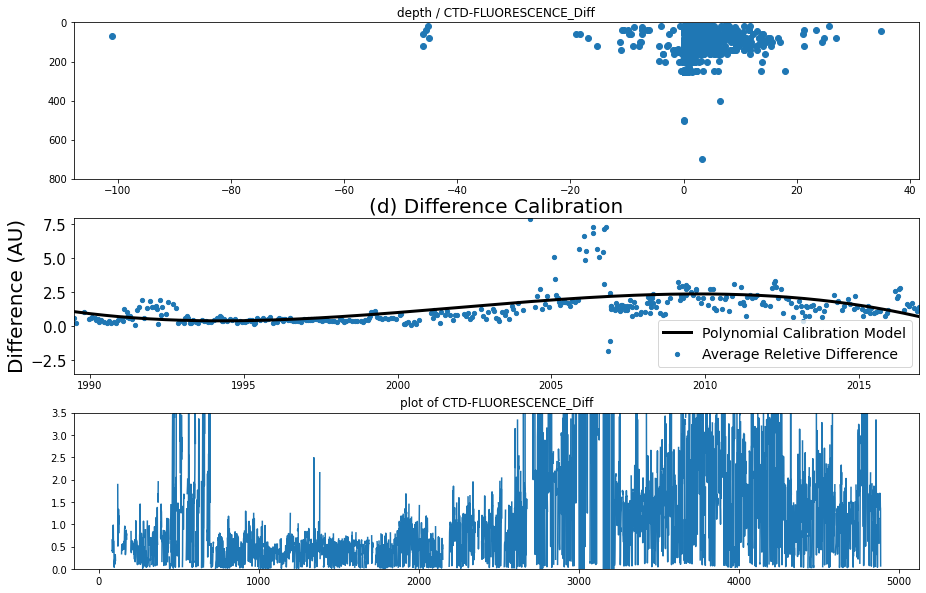

In [31]:
#Define the figure window including 5 subplots orientated horizontally

# fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(12,9), \
# gridspec_kw={'hspace': 0.25}) #(19,13)
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(15.15,10.05), \
gridspec_kw={'hspace': 0.25})

ax1.set_ylim([800,0]) 
ax1.set_title('depth / CTD-FLUORESCENCE_Diff')
ax1.scatter(CALI_Prof_series[:,5],CALI_Prof_series[:,1])

# ax2.set_title('relative difference of ')
# ax2.set_ylim([-1.5,1.5]) 
ax2.set_ylim([-3.5,8]) # -5,10 -0,4
ax2.set_ylabel('Difference (AU)', fontsize= 20, color='k')
ax2.set_title('(d) Difference Calibration', fontsize = 20, color='k')
xnew=Decimal_year #np.linspace(-20,20,100)
ynew=np.poly1d(pfit)
print(ynew)
ax2.scatter(Decimal_year,avg_rel_dif, s = 18, label ='Average Reletive Difference')
# ax2.plot(Decimal_year,avg_rel_dif, label ='Average Reletive Difference')
ax2.plot(xnew,ynew(xnew),linewidth=3, label ='Polynomial Calibration Model', color='k')
ax2.yaxis.set_tick_params(labelsize= 15)
ax2.legend(loc="lower right", fontsize=14)
ax2.set_xlim([1989.4726,2016.9549]) 
# ax2.grid()
# ax2.show()


#  OG ax2.scatter(Decimal_year,avg_rel_dif,xnew,ynew(xnew))




# ax2.plot(Decimal_year,pfit(Decimal_year))
# ax2.scatter(Decimal_year,pfit(Decimal_year),Decimal_year,avg_rel_dif)

ax3.set_title('plot of CTD-FLUORESCENCE_Diff')
ax3.set_ylim([0,3.5]) 
ax3.plot(CALI_Prof_series[:,5])

In [67]:
# Investigate Calibration Model:
print(ynew)
print(mean_absolute_error(avg_rel_dif, ynew(xnew)))
print(median_absolute_error(avg_rel_dif, ynew(xnew)))
STATS_REG  = stats.pearsonr(avg_rel_dif, ynew(xnew))
#pvalue
P_CORR_ST         = ("{0:.3f}".format(STATS_REG[1]))
print(STATS_REG)
print(P_CORR_ST)


           3         2
-0.001061 x + 6.374 x - 1.276e+04 x + 8.516e+06
0.7673155435750133
0.3994501003719855
(0.42158528248913624, 7.714279505075026e-19)
0.000


### Calibrate each profile to Polyfit

#### CTD data, convert to decimal

In [33]:
# 1st, Get ctd data 
result['fluorescence_NPQ'] = fluorescence_NPQ

#and convert to decimal year
CTD_dates = time

df = pd.DataFrame(CTD_dates,columns=['time'])
  
# printing dataframe 
print(df)
  
# checking the type 
print(df.dtypes)

df=pd.to_datetime(df['time'])
print(len(df))
print(df.dtypes)

# no null values already

#get decimal year
Decimal_year_CTD = np.empty(len(time))+nan
for i in range(len(time)):
    Decimal_year_CTD[i] = year_fraction(df[i])
    
print(Decimal_year_CTD)

                           time
0        1989-06-22T12:51:07.00
1        1989-06-22T12:51:07.00
2        1989-06-22T12:51:07.00
3        1989-06-22T12:51:07.00
4        1989-06-22T12:51:07.00
...                         ...
1624719  2016-12-15T23:45:00.00
1624720  2016-12-15T23:45:00.00
1624721  2016-12-15T23:45:00.00
1624722  2016-12-15T23:45:00.00
1624723  2016-12-15T23:45:00.00

[1624724 rows x 1 columns]
time    object
dtype: object
1624724
datetime64[ns]
[1989.47123288 1989.47123288 1989.47123288 ... 2016.95355191 2016.95355191
 2016.95355191]


#### Find calibration at CTD time X using polyfit

In [34]:
poly_chla_dif = ynew(Decimal_year_CTD)
print(poly_chla_dif)

[1.07610752 1.07610752 1.07610752 ... 0.70919243 0.70919243 0.70919243]


#### Apply difference to CTD_Fluorescence

In [35]:
# should subtract chla abs_diff to calibrate (as it was calculated by CTD - Bottle)
result['fluorescence_CALI'] = fluorescence_NPQ * poly_chla_dif
# # For division code
# result['fluorescence_CALI'] = fluorescence_NPQ / poly_chla_dif
fluorescence_CALI  = result.loc[:,'fluorescence_CALI'].to_numpy()

# Contour Plots, with new Calibrated Fluorescence

In [36]:
# Set xy (area) of contour plot
y = 1000
x = len(ID_list)

#Depth
New_depth = np.array(range(0, 1000))

# Temperature
temp     = np.empty([x,y])+nan
Depth_2  = np.empty([x,y])+nan
CHLA_1   = np.empty([x,y])+nan
CHLA_2   = np.empty([x,y])+nan
Time_2   = (np.empty([x,y], dtype='datetime64[s]'))
COMBI    = np.empty([x,y])+nan
Time_3   = (np.empty([x,y], dtype='datetime64[s]'))
Depth_3  = np.empty([x,y])+nan

count = 0
for i in ID_list:
    if len(depth[result.cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(depth[result.cruise_ID == i],temperature[result.cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        temp[count,:]    = xxx
        AD               = time[result.cruise_ID == i]
        Time_2[count,:]  = AD[0]    
        Depth_2[count,:] = New_depth
    count=count+1
    
count = 0    
for i in ID_list:
    if len(depth[result.cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(depth[result.cruise_ID == i],fluorescence_CALI[result.cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        CHLA_2[count,:]  = xxx
    count=count+1

count = 0    
for i in ID_list:
    if len(depth[result.cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(depth[result.cruise_ID == i],fluorescence[result.cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        CHLA_1[count,:]  = xxx
    count=count+1
    
# for bottle data
count = 0    
for i in ID_list_b:
    if len(b_depth[bottle.Cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(b_depth[bottle.Cruise_ID == i],b_pig22[bottle.Cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        COMBI[count,:]   = xxx
        AD               = b_time[bottle.Cruise_ID == i]
        Time_3[count,:]  = AD[0]    
        Depth_3[count,:] = New_depth

    count=count+1

### Plot

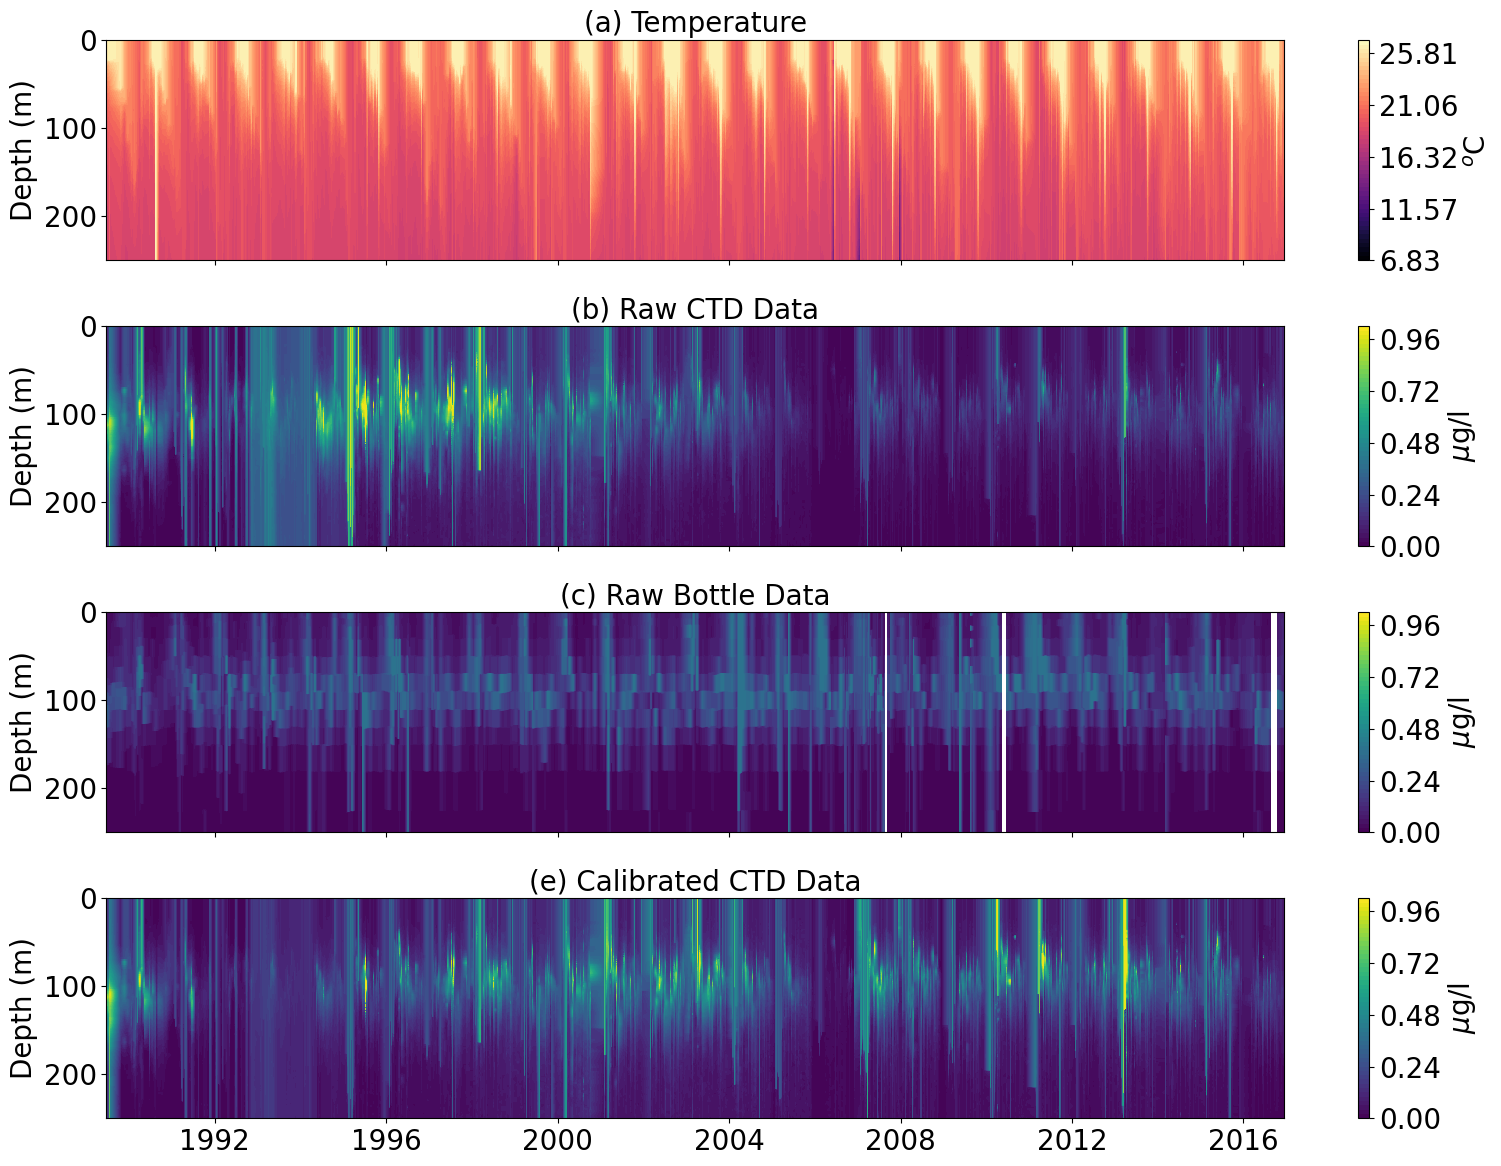

In [37]:
#Figure parameters that can be changed 
TEMP_COL          = mpl.cm.magma  #Temp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
PSAL_COL          = mpl.cm.winter #Salinity colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
DOXY_COL          = mpl.cm.copper #Diss OXY colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
CHLA_COL          = mpl.cm.viridis#Chl-a colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
BBP_COL           = mpl.cm.cividis#bbp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
XSIZE             = 19            #Define the xsize of the figure window
YSIZE             = 14            #Define the ysize of the figure window
Title_font_size   = 20            #Define the font size of the titles
Label_font_size_x = 20            #Define the font size of the x-labels
Label_font_size_y = 20            #Define the font size of the y-labels
Cbar_title_size   = 20            #Define the font size of the Colourbar title
Cbar_label_size   = 20            #Define the font size of the Colourbar labels
Percentiles_upper = 99            #Upper percentiles used to constrain the colour scale
Percentiles_lower = 1  
#Define the figure window including 5 subplots orientated vertically
plt.style.use('default')
fig, (ax1,ax3,ax5,ax2) = plt.subplots(4, sharex=True, figsize=(XSIZE,YSIZE), #\                          
    gridspec_kw={'hspace': 0.3})
    
#x axistest#
xaxi = [date(1989,6,22),date(2016,12,15)]

#SUBPLOT 1: TEMPERATURE TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = temp
PCT_1          = np.nanpercentile(temp, Percentiles_lower)
PCT_2          = np.nanpercentile(temp, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im1            = ax1.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = TEMP_COL)
##Set axis info and titles
ax1.set_ylim([250,0]) 
ax1.set_xlim([xaxi[0],xaxi[-1]]) 
ax1.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax1.set_title('(a) Temperature', fontsize = Title_font_size, color='k')
ax1.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=5)
cbar1.set_label("$^o$C", size  = Cbar_title_size)
cbar1.ax.tick_params(labelsize = Cbar_label_size)
# ax1.plot(Decimal_year_2,MLD_2)



#SUBPLOT 5: CHL A/ FLu calibration TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_2
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = 0.0
PCT_2 = 1
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im2            = ax2.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = CHLA_COL)
##Set axis info and titles
ax2.set_ylim([250,0]) 
ax2.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax2.set_title('(e) Calibrated CTD Data', fontsize = Title_font_size, color='k')
ax2.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax2.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=5)
cbar2.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar2.ax.tick_params(labelsize = Cbar_label_size)

# #subplot 4: Calibration curve
# ax4.set_ylabel('Difference (AU)', fontsize= 20, color='k')
# ax4.set_title('(d) Difference Calibration (AU)', fontsize = 20, color='k')
# xnew=Decimal_year #np.linspace(-20,20,100)
# ynew=np.poly1d(pfit)
# ax4.scatter(Decimal_year,avg_rel_dif, s = 20)
# ax4.plot(xnew,ynew(xnew),linewidth=3)

#SUBPLOT 2: CHL A TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_1
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = 0.0
PCT_2 = 1
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im3            = ax3.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = CHLA_COL)
##Set axis info and titles
ax3.set_ylim([250,0]) 
ax3.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax3.set_title('(b) Raw CTD Data', fontsize = Title_font_size, color='k')
ax3.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax3.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar3 = fig.colorbar(im3, ax=ax3)
cbar3.ax.locator_params(nbins=5)
cbar3.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar3.ax.tick_params(labelsize = Cbar_label_size)

#SUBPLOT 3: TEMPERATURE TIME-SERIES
#Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = COMBI
PCT_1          =  0 #np.nanpercentile(CTD_CHLA, Percentiles_lower)
PCT_2          = 0.4#np.nanpercentile(CTD_CHLA, Percentiles_upper)
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
# levels         = np.arange(PCT_1, PCT_2+((PCT_2-PCT_1)/49.), (PCT_2-PCT_1)/50.)
im5            = ax5.contourf(Time_3, Depth_3, IN_DATA, levels,cmap = CHLA_COL)
##Set axis info and titles
ax5.set_ylim([250,0]) 
ax5.set_xlim([xaxi[0],xaxi[-1]]) 
ax5.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax5.set_title('(c) Raw Bottle Data', fontsize = Title_font_size, color='k')
ax5.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax5.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar5 = fig.colorbar(im5, ax=ax5)
cbar5.ax.locator_params(nbins=5)
cbar5.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar5.ax.tick_params(labelsize = Cbar_label_size)

In [47]:
print('1000m Orginal Data')
print('Temp')
q75, q25 = np.nanpercentile(temperature, [75 ,25])
print(np.nanmean(temperature))
print(q75, q25)

print('Fluorescence')
q75, q25 = np.nanpercentile(fluorescence, [75 ,25])
print(np.nanmean(fluorescence))
print(q75, q25)

print('Chl-a')
q75, q25 = np.nanpercentile(b_pig22, [75 ,25])
print(np.nanmean(b_pig22))
print(q75, q25)

print('Calibrated Fluorescence')
q75, q25 = np.nanpercentile(fluorescence_CALI, [75 ,25])
print(np.nanmean(fluorescence_CALI))
print(q75, q25)
print('')
print('1000m Interpolated Data')
print('Temp')
q75, q25 = np.nanpercentile(temp, [75 ,25])
print(np.nanmean(temp))
print(q75, q25)

print('Fluorescence')
q75, q25 = np.nanpercentile(CHLA_1, [75 ,25])
print(np.nanmean(CHLA_1))
print(np.nanmedian(CHLA_1))
print(q75, q25)

print('Chl-a')
q75, q25 = np.nanpercentile(COMBI, [75 ,25])
print(np.nanmean(COMBI))
print(np.nanmedian(COMBI))
print(q75, q25)

print('Calibrated Fluorescence')
q75, q25 = np.nanpercentile(CHLA_2, [75 ,25])
print(np.nanmean(CHLA_2))
print(np.nanmedian(CHLA_2))
print(q75, q25)

print('')
print('Turner/HPLC Difference')
chla_dif = b_pig16 - b_pig14
print(np.nanmean(chla_dif))
# tryy [bottle.depth < 250] ##########

1000m Orginal Data
Temp
16.361342475417693
18.8047 14.0045
Fluorescence
0.055682377049766196
0.054 0.013927120320450924
Chl-a
0.13565400326797386
0.199625 0.039875
Calibrated Fluorescence
0.06287091918143224
0.06100835625641048 0.02474392664822065

1000m Interpolated Data
Temp
16.710578486064936
18.6313 15.7606
Fluorescence
0.06017491193586907
0.021
0.055 0.013
Chl-a
0.04646427060133628
0.0069999999999999
0.049 0.0015
Calibrated Fluorescence
0.060275617342599994
0.03448672262951732
0.05825904955714941 0.02311644507572055

Turner/HPLC Difference
0.012483619344773787


## Fit Model

#### Fix result fluorescence

In [48]:
#Read CSV from CMAP
filename = 'thousand_m_BATS.csv'
result2   = pd.read_csv(filename)

# Removes rows with NaN fluorescence values(~4000 rows)
result2 = result2.dropna(subset=['fluorescence'], inplace=False)

# Removes rows with NaN temperature values (~1200 rows)
result2 = result2.dropna(subset=['temperature'], inplace=False)

# #Removes '0Z' from the end of time column values
result2['time'] = result2['time'].str[:-2]

# # result.to_csv(r'C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\Scripts\dataset_1001_check_2.csv')


# sort odd profile
# print(result2[result2.cruise_ID == 50047049])
# result[result.cruise_ID == 50047049].sort_values(by='depth')
result2.sort_values(by=['time','depth'], inplace=True)

# print(result2[result2.cruise_ID == 50047049])


In [49]:
fluorescence  = result2.loc[:,'fluorescence'].to_numpy()

#### Plot raw fluorescence Vs. calibrated chla

(array([4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883,
       4884], dtype=int64),)


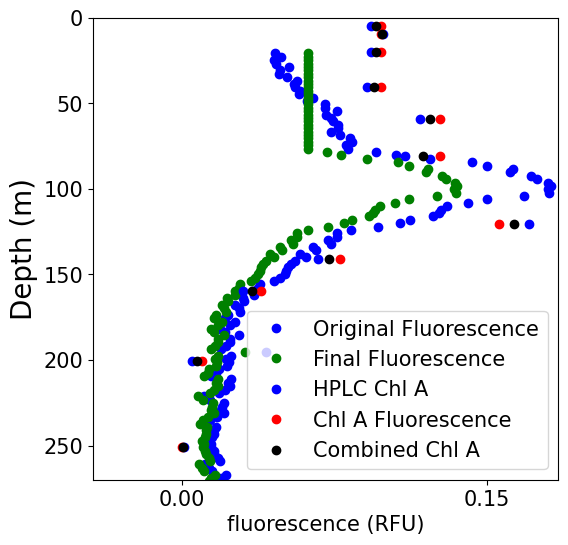

In [50]:
# Fetch single profile
# print(result[result.cruise_ID == ID_1])
ID_1 = 10330011
#10330011 10232005 # bottle id
x = np.where(result.cruise_ID == ID_1)
AS = np.where(bottle.Cruise_ID == ID_1) #ID_1
print(AS)
depth_1        = depth[x]
temperature_1  = temperature[x]
fluorescence_1 = fluorescence_CALI[x]
fluorescence_2 = fluorescence[x]
b_pig16_1      = b_pig16[AS]
b_pig14_1      = b_pig14[AS]
b_pig22_1      = b_pig22[AS]
b_depth_1      = b_depth[AS]

#Plot optical depth
XSIZE = 6 #Define the xsize of the figure window
YSIZE = 6 #Define the ysize of the figure window

#Define the figure window including 5 subplots orientated horizontally
fig, (ax3) = plt.subplots(1, sharey=True, figsize=(XSIZE,YSIZE), \
gridspec_kw={'hspace': 0})

ax3.plot(fluorescence_2,depth_1, \
         color = 'b', marker = 'o', linestyle = 'None', label= 'Original Fluorescence')
ax3.plot(fluorescence_1,depth_1, \
         color = 'g', marker = 'o', linestyle = 'None', label= 'Final Fluorescence')
ax3.plot(b_pig14_1,b_depth_1, \
         color = 'b', marker = 'o', linestyle = 'None', label= 'HPLC Chl A')
ax3.plot(b_pig16_1,b_depth_1, \
         color = 'r', marker = 'o', linestyle = 'None', label= 'Chl A Fluorescence')
ax3.plot(b_pig22_1,b_depth_1, \
         color = 'k', marker = 'o', linestyle = 'None', label= 'Combined Chl A')
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.set_ylim([270,0]) 
ax3.set_xlabel('fluorescence (RFU)', fontsize=15, color = 'k')
ax3.xaxis.set_tick_params(labelsize=15)
ax3.set_xlim(xmin=np.min(fluorescence_1)-0.05, xmax=np.max(fluorescence_1)+0.05)
ax3.legend(loc="lower right", fontsize=15)
ax3.xaxis.set_major_locator(plt.MaxNLocator(2))

#Complete the plot
plt.show()

In [51]:
print(MLD)
print(len(MLD))
print(len(ID_list))

[ 22.83888949  21.20952463  20.85285035 ... 100.27923704 120.12526401
  89.35806502]
4659
4659


#### Apply Brewin Model to single profile

In [52]:
prof_MLD_idx = np.where(ID_list == ID_1)
prof_MLD     = MLD[prof_MLD_idx]
prof_depth   = depth[np.where(result.cruise_ID == ID_1)]
prof_chla    = fluorescence_CALI[np.where(result.cruise_ID == ID_1)]
x1           = np.where(prof_depth <= prof_MLD)
prof_chla_surf=np.nanmedian(prof_chla[x1])


# Equation for euphotic depth https://doi.org/10.1016/j.rse.2007.03.012
Kd = 4.6 / 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)

# Normalise profile
#####################Chlorophyll fit##################
###Dimensionalise the profiles
CHL_DIM  = prof_chla/prof_chla_surf  #Dimensionless chl
OPT_DIM  = prof_depth*Kd   #Dimensionless tau
MLD_OD   = prof_MLD*Kd                 #Optical depth of mixed layer

###Only select data <9.2 Optical depths if MLD_opt < 9.2
if MLD_OD < 9.2:
    valid1  = np.where(OPT_DIM < 9.2)#
    CHL_DIM = CHL_DIM[valid1]
    OPT_DIM = OPT_DIM[valid1]
###Process data to be used for Chl fit
X1        = CHL_DIM
X1        = np.array(X1,dtype='float32')
Y1        = OPT_DIM
Y1        = np.array(Y1,dtype='float32')
a         = np.isnan(X1)
X1        = np.delete(X1, a, 0)
Y1        = np.delete(Y1, a, 0)
a         = np.isnan(Y1)
X1        = np.delete(X1, a, 0)
Y1        = np.delete(Y1, a, 0)

# valid1    = np.logical_not(ma.getmask(X1))
# X1        = X1[valid1]
# Y1        = Y1[valid1]
# valid1    = np.logical_not(ma.getmask(Y1))
# X1        = X1[valid1]
# Y1        = Y1[valid1]
## Profile has to have as a minimum of more measurements +1 than parameters (6 for Eq. 7)        
if len(X1) > 6:
    ###Fit 1st population
    params1  = Parameters()
    params1.add('P1', value=9., min = 4.6, max = 100)
    params1.add('P2', value=MLD_OD[0])#MLD_OD
    out      = Minimizer(fcn2min_1pop, params1, fcn_args=(X1, Y1))
    result_3   = out.minimize()
    P1_FIT   = result_3.params['P1'].value
    P2_FIT   = result_3.params['P2'].value
    AIC_FIT1 = result_3.aic
    CHI_FIT1 = result_3.chisqr
    MLD_pop  = 1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y1-P2_FIT)))
    r        = np.corrcoef(X1, MLD_pop)
    report_fit(result_3) ##uncomment if you want to see results of fit
    ###Fit 2nd population
    params2 = Parameters()
    if r[1,0]**2 >= 0.90: 
        P3_FIT = nan
        P4_FIT = nan
        P5_FIT = nan
    else:
    ###Estimate tau1 and S1 from Optical depth of mixed layer  
        Tau1_temp = (MLD_OD[0]*0.62)+2.296
        P1_temp   = 10**(0.08 * Tau1_temp + 0.66)
        params2.add('P1', value=P1_temp, vary=False) #Fixed
        params2.add('P2', value=Tau1_temp, vary=False) #Fixed
        params2.add('P3', value=5.0, min = 0.0, max = 100.0)
        params2.add('P4', value=4.6, min = 0.0)
        params2.add('P5', value=1.0, min = 0.0)
        res      = Minimizer(fcn2min_2pop,  params2, fcn_args=(X1, Y1))
        result_3 = res.minimize()
        AIC_FIT2 = result_3.aic
        CHI_FIT2 = result_3.chisqr
        report_fit(result_3) ##uncomment if you want to see results of fit
        if AIC_FIT2 < AIC_FIT1: 
#         if   AIC_FIT1 < AIC_FIT2: 
            P1_FIT = result_3.params['P1'].value
            P2_FIT = result_3.params['P2'].value
            P3_FIT = result_3.params['P3'].value
            P4_FIT = result_3.params['P4'].value
            P5_FIT = result_3.params['P5'].value
        else:
            P3_FIT = nan
            P4_FIT = nan
            P5_FIT = nan
else:
    P1_FIT = nan
    P2_FIT = nan
    P3_FIT = nan
    P4_FIT = nan
    P5_FIT = nan
###Extract parameters from the xhlorophyll fit
P1_TEMP   = P1_FIT                                                                                                         
TAU1_TEMP = P2_FIT
BM2_TEMP  = P3_FIT
TAU2_TEMP = P4_FIT + P5_FIT * 3.0
SIG2_TEMP = P5_FIT    

###CHL MODEL
OPT_DIM  = prof_depth*Kd
MLD_pop_FIT   = (1 - 1./(1+np.exp(-(P1_TEMP/TAU1_TEMP)*(OPT_DIM-TAU1_TEMP))))*prof_chla_surf
DCM_pop_FIT   = (BM2_TEMP*np.exp(-((OPT_DIM - TAU2_TEMP)/SIG2_TEMP)**2.)) *prof_chla_surf
CHL_model_fit = MLD_pop_FIT + DCM_pop_FIT

print(MLD_OD)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 90
    # variables        = 2
    chi-square         = 15.416939
    reduced chi-square = 0.17519249
    Akaike info crit   = -154.790856
    Bayesian info crit = -149.791237
[[Variables]]
    P1:  13.0554818 +/- 4.88338131 (37.40%) (init = 9)
    P2:  7.44270946 +/- 0.23562191 (3.17%) (init = 3.547366)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 90
    # variables        = 3
    chi-square         = 4.468897
    reduced chi-square = 0.05136663
    Akaike info crit   = -264.240127
    Bayesian info crit = -256.740698
[[Variables]]
    P1:  10.46235 (fixed)
    P2:  4.495367 (fixed)
    P3:  1.52092738 +/- 0.06079126 (4.00%) (init = 5)
    P4:  0.54781669 +/- 0.21590750 (39.41%) (init = 4.6)
    P5:  1.51835269 +/- 0.07004843 (4.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(P4, P5) = -0.973
  

#### Troubleshooting

In [ ]:
# print(OPT_DIM)
print(MLD_pop_FIT)

# # DCM + CHL are nan

# print(DCM_pop_FIT)

# print(BM2_TEMP)
# print(TAU2_TEMP)
# print(SIG2_TEMP)
# Variables that make DCM_pop_FIT are NaN as they are made from 
# P3,4,5_FIT variables, which are made NaN in final 'if' Statement

# print(P1_FIT)
# print(P2_FIT)
print(AIC_FIT2,'is not <',AIC_FIT1)

# print(P3_FIT)
# print(P4_FIT)
# print(P5_FIT)

print(Kd)
print(len(CHL_DIM))
print(len(OPT_DIM))
print(MLD_OD)

# print(CHL_model_fit)

# print(type(params1))

# print(type(X1[1]))
# print(type(MLD_OD[0]))
# print((MLD_OD))

# print((prof_depth))
# print((prof_chla))
# print(len(X1))

#### Plot model of profile

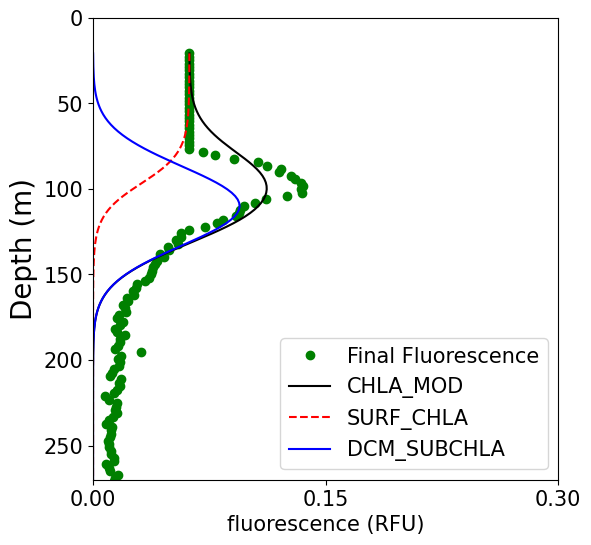

In [53]:
#Plot optical depth
XSIZE = 6 #Define the xsize of the figure window
YSIZE = 6 #Define the ysize of the figure window

#Define the figure window including 5 subplots orientated horizontally
fig, (ax3) = plt.subplots(1, sharey=True, figsize=(XSIZE,YSIZE), \
gridspec_kw={'hspace': 0})


ax3.plot(prof_chla,prof_depth, \
         color = 'g', marker = 'o', linestyle = 'None', label= 'Final Fluorescence')
ax3.plot(CHL_model_fit,prof_depth, \
         color = 'k', linestyle = '-', label= 'CHLA_MOD')
ax3.plot(MLD_pop_FIT,prof_depth, \
         color = 'r', linestyle = '--', label= 'SURF_CHLA')
ax3.plot(DCM_pop_FIT,prof_depth, \
         color = 'b', linestyle = '-', label= 'DCM_SUBCHLA')
ax3.set_ylabel('Depth (m)', fontsize=20)
ax3.yaxis.set_tick_params(labelsize=15)
ax3.set_ylim([270,0]) 
ax3.set_xlabel('fluorescence (RFU)', fontsize=15, color = 'k')
ax3.xaxis.set_tick_params(labelsize=15)
# ax3.set_xlim(xmin=np.min(fluorescence_1)-0.05, xmax=np.max(fluorescence_1)+0.05)
ax3.set_xlim(0,0.3)
ax3.legend(loc="lower right", fontsize=15)
ax3.xaxis.set_major_locator(plt.MaxNLocator(2))

plt.show()

### Intergration

In [54]:
sub_int             = spi.trapz(DCM_pop_FIT,prof_depth)
surf_int            = spi.trapz(MLD_pop_FIT,prof_depth)
Total_CHL_model_int = spi.trapz(CHL_model_fit,prof_depth)
raw_chl_data_int    = spi.trapz(prof_chla,prof_depth)
print(sub_int) 
print(surf_int) 
print(Total_CHL_model_int)


print(np.array(range(len(fluorescence_CALI))) + np.nan)
len(fluorescence_CALI)

5.4839563165207075
4.726941182380837
10.210897498901543
[nan nan nan ... nan nan nan]


1624724

#### Loop Intergration

In [55]:
MLD_pop_FIT   = np.array(range(len(fluorescence_CALI))) + nan
DCM_pop_FIT   = np.array(range(len(fluorescence_CALI))) + nan
CHL_model_fit = np.array(range(len(fluorescence_CALI))) + nan

count = 0
for ID_1 in ID_list:
    where_result_idx    = np.where(result.cruise_ID == ID_1)

    prof_MLD_idx = np.where(ID_list == ID_1)
    prof_MLD     = MLD[prof_MLD_idx]
    prof_depth   = depth[where_result_idx]
    prof_chla    = fluorescence_CALI[where_result_idx]
    x1           = np.where(prof_depth <= prof_MLD)
    prof_chla_surf=np.nanmedian(prof_chla[x1])


    # Equation for euphotic depth https://doi.org/10.1016/j.rse.2007.03.012
    Kd = 4.6 / 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
    0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)

    # Normalise profile
    #####################Chlorophyll fit##################
    ###Dimensionalise the profiles
    CHL_DIM  = prof_chla/prof_chla_surf  #Dimensionless chl
    OPT_DIM  = prof_depth*Kd   #Dimensionless tau
    MLD_OD   = prof_MLD*Kd                 #Optical depth of mixed layer

    ###Only select data <9.2 Optical depths if MLD_opt < 9.2
    if MLD_OD < 9.2:
        valid1  = np.where(OPT_DIM < 9.2)#
        CHL_DIM = CHL_DIM[valid1]
        OPT_DIM = OPT_DIM[valid1]
    ###Process data to be used for Chl fit
    X1        = CHL_DIM
    X1        = np.array(X1,dtype='float32')
    Y1        = OPT_DIM
    Y1        = np.array(Y1,dtype='float32')
    a         = np.isnan(X1)
    X1        = np.delete(X1, a, 0)
    Y1        = np.delete(Y1, a, 0)
    a         = np.isnan(Y1)
    X1        = np.delete(X1, a, 0)
    Y1        = np.delete(Y1, a, 0)

    # valid1    = np.logical_not(ma.getmask(X1))
    # X1        = X1[valid1]
    # Y1        = Y1[valid1]
    # valid1    = np.logical_not(ma.getmask(Y1))
    # X1        = X1[valid1]
    # Y1        = Y1[valid1]
    ## Profile has to have as a minimum of more measurements +1 than parameters (6 for Eq. 7)        
    if len(X1) > 6:
        ###Fit 1st population
        params1  = Parameters()
        params1.add('P1', value=9., min = 4.6, max = 100)
        params1.add('P2', value=MLD_OD[0])#MLD_OD
        out      = Minimizer(fcn2min_1pop, params1, fcn_args=(X1, Y1))
        result_3   = out.minimize()
        P1_FIT   = result_3.params['P1'].value
        P2_FIT   = result_3.params['P2'].value
        AIC_FIT1 = result_3.aic
        CHI_FIT1 = result_3.chisqr
        MLD_pop  = 1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y1-P2_FIT)))
        r        = np.corrcoef(X1, MLD_pop)
    #     report_fit(result_3) ##uncomment if you want to see results of fit
        ###Fit 2nd population
        params2 = Parameters()
        if r[1,0]**2 >= 0.90: 
            P3_FIT = nan
            P4_FIT = nan
            P5_FIT = nan
        else:
        ###Estimate tau1 and S1 from Optical depth of mixed layer  
            Tau1_temp = (MLD_OD[0]*0.62)+2.296
            P1_temp   = 10**(0.08 * Tau1_temp + 0.66)
            params2.add('P1', value=P1_temp, vary=False) #Fixed
            params2.add('P2', value=Tau1_temp, vary=False) #Fixed
            params2.add('P3', value=5.0, min = 0.0, max = 100.0)
            params2.add('P4', value=4.6, min = 0.0)
            params2.add('P5', value=1.0, min = 0.0)
            res      = Minimizer(fcn2min_2pop,  params2, fcn_args=(X1, Y1))
            result_3 = res.minimize()
            AIC_FIT2 = result_3.aic
            CHI_FIT2 = result_3.chisqr
    #         report_fit(result_3) ##uncomment if you want to see results of fit
            if AIC_FIT2 < AIC_FIT1: 
    #         if   AIC_FIT1 < AIC_FIT2: 
                P1_FIT = result_3.params['P1'].value
                P2_FIT = result_3.params['P2'].value
                P3_FIT = result_3.params['P3'].value
                P4_FIT = result_3.params['P4'].value
                P5_FIT = result_3.params['P5'].value
            else:
                P3_FIT = nan
                P4_FIT = nan
                P5_FIT = nan
    else:
        P1_FIT = nan
        P2_FIT = nan
        P3_FIT = nan
        P4_FIT = nan
        P5_FIT = nan
    ###Extract parameters from the xhlorophyll fit
    P1_TEMP   = P1_FIT                                                                                                         
    TAU1_TEMP = P2_FIT
    BM2_TEMP  = P3_FIT
    TAU2_TEMP = P4_FIT + P5_FIT * 3.0
    SIG2_TEMP = P5_FIT    

    ###CHL MODEL
    OPT_DIM  = prof_depth*Kd
    if np.isnan(BM2_TEMP): 
        MLD_pop_FIT[where_result_idx]   = (1 - 1./(1+np.exp(-(P1_TEMP/TAU1_TEMP)*(OPT_DIM-TAU1_TEMP))))*prof_chla_surf
        DCM_pop_FIT[where_result_idx]   = MLD_pop_FIT[where_result_idx] *0
    else:
        MLD_pop_FIT[where_result_idx]   = (1 - 1./(1+np.exp(-(P1_TEMP/TAU1_TEMP)*(OPT_DIM-TAU1_TEMP))))*prof_chla_surf
        DCM_pop_FIT[where_result_idx]   = (BM2_TEMP*np.exp(-((OPT_DIM - TAU2_TEMP)/SIG2_TEMP)**2.)) *prof_chla_surf
    CHL_model_fit[where_result_idx] = MLD_pop_FIT[where_result_idx] + DCM_pop_FIT[where_result_idx]
    print(count)
    count=count+1
    

0
1
2
3
4
5
6
7
8
9


C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:63: RuntimeWarning: overflow encountered in exp
  MLD_pop  = 1 - 1./(1+np.exp(-(P1_FIT/P2_FIT)*(Y1-P2_FIT)))


10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
3

C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:18: RuntimeWarning: invalid value encountered in log10
  Kd = 4.6 / 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:19: RuntimeWarning: invalid value encountered in log10
  0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)


1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406


C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:18: RuntimeWarning: divide by zero encountered in log10
  Kd = 4.6 / 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:19: RuntimeWarning: divide by zero encountered in log10
  0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:18: RuntimeWarning: invalid value encountered in double_scalars
  Kd = 4.6 / 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2907049710.py:24: RuntimeWarning: invalid value encountered in true_divide
  CHL_DIM  = prof_chla/prof_chla_surf  #Dimensionless chl


2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931
2932
2933
2934
2935
2936
2937
2938
2939
2940
2941
2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989


4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628


In [56]:
# Input model results too main df
result['surf_model']  = MLD_pop_FIT
result['sub_model']   = DCM_pop_FIT
result['total_model'] = CHL_model_fit


In [58]:
# ## Stats, finding difference of model

## Create new result df with only top 250m
result3 = result[result['depth'] <= 250]  
# print(result3)

# # Loop
# CHL_model_fit_250 = result3['total_model']
# fluorescence_CALI_250 = result3['fluorescence_CALI']
# Com1_250 = result3['surf_model']
# Com1_250_1 = Com1_250[result3.sub_model >= 0.1]
# Com2_250 = result3['sub_model']
depth_250 = result3['depth']
depth_250 = depth_250[result3.sub_model >= 0.2]

# Mod_Difference = []
# Data_stats     = []
# Mod_stats      = []
# Com1_stats     = []
# Com1_stats_1     = []
# Com2_stats     = []
Com1_depth     = np.array(range(len(ID_list))) + np.nan
count=0
for i in ID_list:
#     Mod_Difference = np.append(Mod_Difference,
#                                CHL_model_fit_250[result3.cruise_ID == i] - fluorescence_CALI_250[result3.cruise_ID == i],
#                                axis=0)
# # Just for FluCali stats
#     Data_stats = np.append(Data_stats,
#                           fluorescence_CALI_250[result3.cruise_ID == i],
#                           axis=0)
# # Just for Model stats
#     Mod_stats = np.append(Mod_stats,
#                           CHL_model_fit_250[result3.cruise_ID == i],
#                           axis=0)
# # Just for Community 1 Model stats
#     Com1_stats = np.append(Com1_stats,
#                           Com1_250[result3.cruise_ID == i],
#                           axis=0)
# Just for Community 1 Model stats with clipped chla
#     Com1_stats_1 = np.append(Com1_stats_1,
#                           Com1_250_1[result3.cruise_ID == i],
#                           axis=0)
# Community 1 Max depth Model stats
    Com1_depth[count] = np.max(depth_250[result3.cruise_ID == i])

# # Just for Community 2 Model stats
#     Com2_stats = np.append(Com2_stats,
#                           Com2_250[result3.cruise_ID == i],
#                           axis=0)
    count=count+1
# Data overview
print('Mod_Difference_stats')
q75, q25 = np.nanpercentile(Mod_Difference, [75 ,25])
print(np.nanmean(Mod_Difference))
print(q25, q75)
print('Data_stats')
q75, q25 = np.nanpercentile(Data_stats, [75 ,25])
print(np.nanmean(Data_stats))
print(q25, q75)
print('Model_stats')
q75, q25 = np.nanpercentile(Mod_stats, [75 ,25])
print(np.nanmean(Mod_stats))
print(q25, q75)
print('Com1_stats')
q75, q25 = np.nanpercentile(Com1_stats, [75 ,25])
print(np.nanmean(Com1_stats))
print(q25, q75)
# Depth
print('Com1_depth')
q75, q25 = np.nanpercentile(Com1_depth, [75 ,25])
print(np.nanmean(Com1_depth))
print(q25, q75)
print('Com1_stats_0.1')
q75, q25 = np.nanpercentile(Com1_stats_1, [75 ,25])
print(np.nanmean(Com1_stats_1))
print(q25, q75)
print('Com2_stats')
q75, q25 = np.nanpercentile(Com2_stats, [75 ,25])
print(np.nanmean(Com2_stats))
print(q25, q75)


Mod_Difference_stats


NameError: name 'Mod_Difference' is not defined

In [59]:
# np.max(depth_250[result3.cruise_ID == 10330011])
# print(len(Com1_stats))
# print(count)

# print(ID_list[0])
# np.max(depth_250[result3.cruise_ID == 10009005])
# Com1_depth     = []
# Com1_depth = np.append(Com1_depth,
#                               np.max(depth_250[result3.cruise_ID == 10009005]),
#                               axis=0)
print(len(MLD))
print(len(MLD_pop_FIT))


4659
1624724


In [60]:
#Contour to show result
#Interp integrated data
y = 1000
x = len(ID_list)

CHLA_m_surf   = np.empty([x,y])+nan
CHLA_m_subb   = np.empty([x,y])+nan
CHLA_m_totl   = np.empty([x,y])+nan

count = 0    
for i in ID_list:
    if len(depth[result.cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(depth[result.cruise_ID == i],MLD_pop_FIT[result.cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        CHLA_m_surf[count,:]  = xxx
    count=count+1

count = 0    
for i in ID_list:
    if len(depth[result.cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(depth[result.cruise_ID == i],DCM_pop_FIT[result.cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        CHLA_m_subb[count,:]  = xxx
    count=count+1
    
count = 0    
for i in ID_list:
    if len(depth[result.cruise_ID == i]) > 1:
        interpfunc       = interpolate.interp1d(depth[result.cruise_ID == i],CHL_model_fit[result.cruise_ID == i], kind='nearest',fill_value="extrapolate")
        xxx              = interpfunc(New_depth)
        CHLA_m_totl[count,:]  = xxx
    count=count+1
  

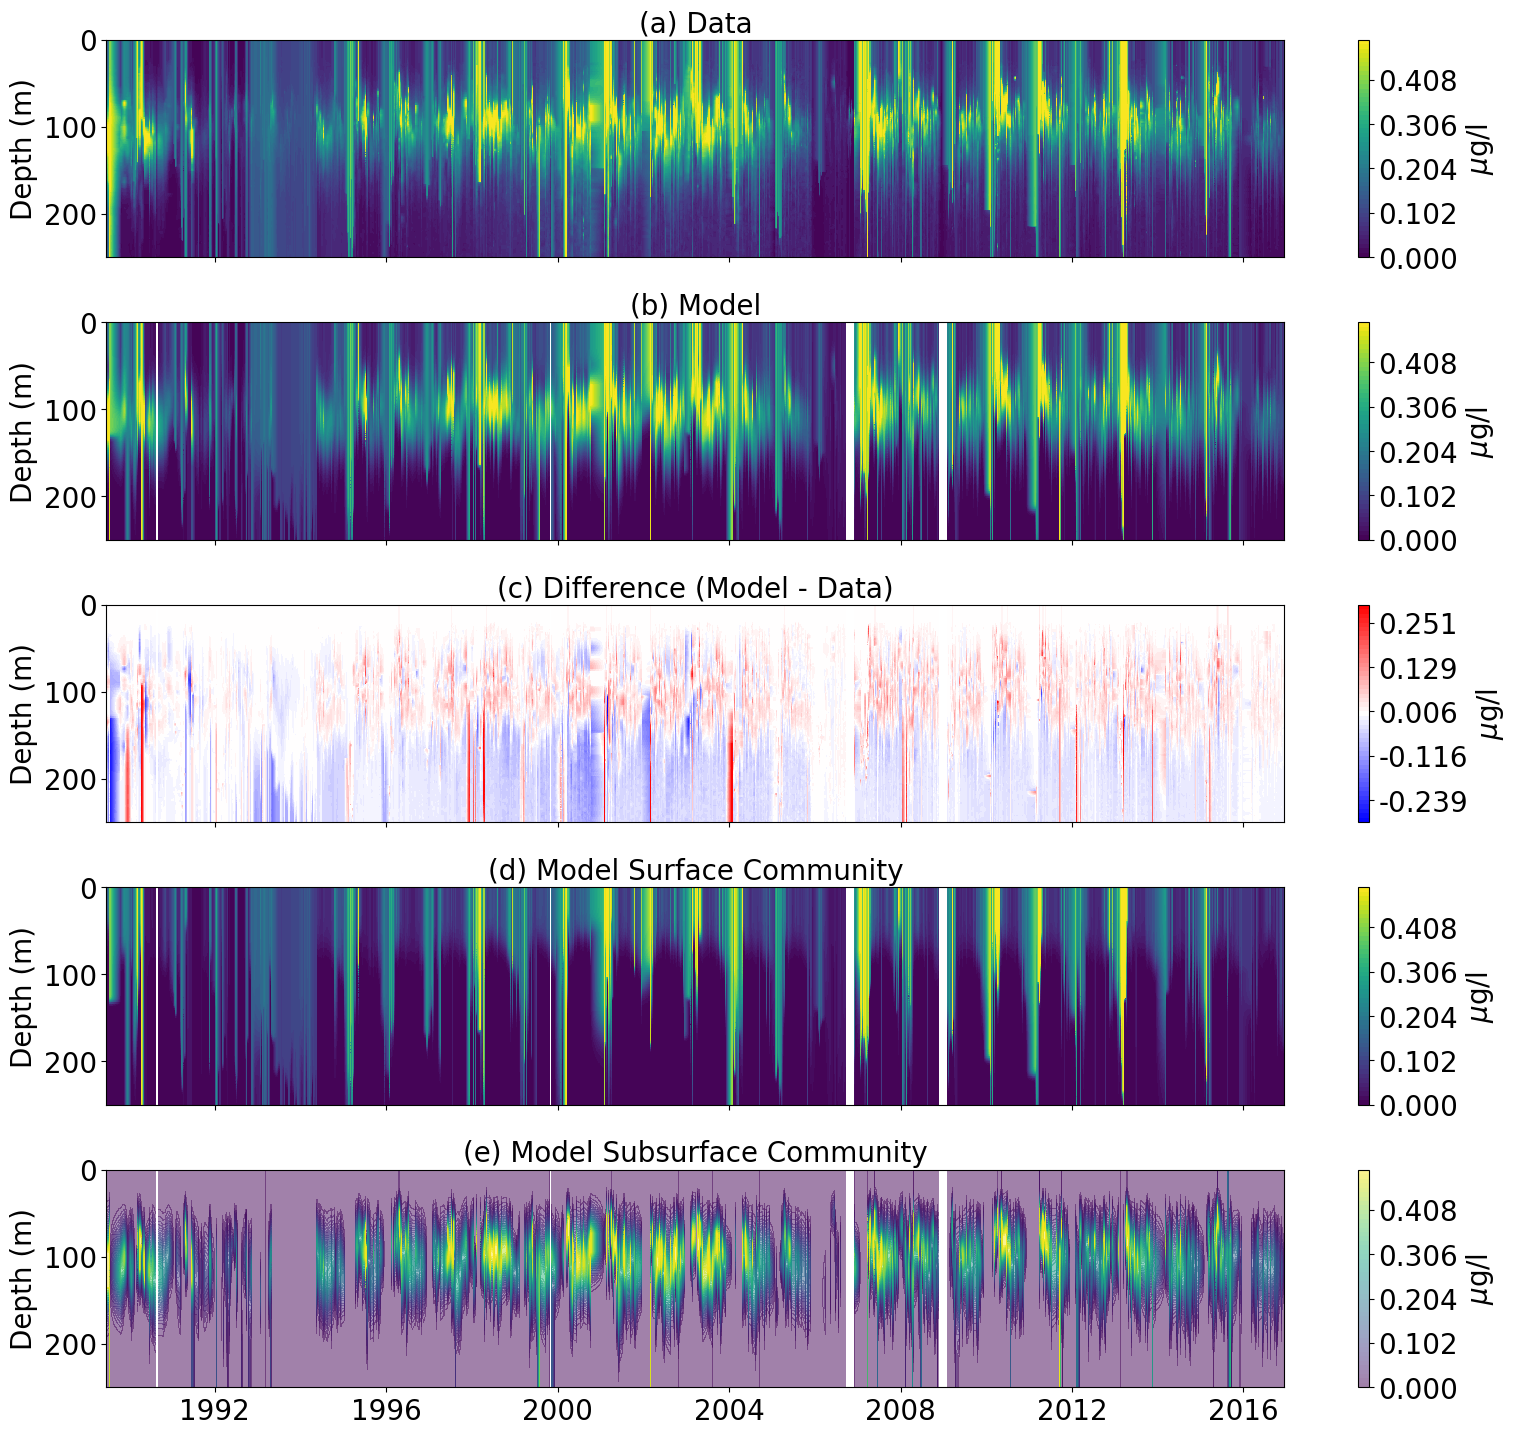

In [74]:
#Figure parameters that can be changed 
TEMP_COL          = mpl.cm.magma  #Temp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
PSAL_COL          = mpl.cm.winter #Salinity colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
DOXY_COL          = mpl.cm.copper #Diss OXY colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
CHLA_COL          = mpl.cm.viridis#Chl-a colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
BBP_COL           = mpl.cm.cividis#bbp colour scale (see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
XSIZE             = 19            #Define the xsize of the figure window
YSIZE             = 17.5            #Define the ysize of the figure window
Title_font_size   = 20            #Define the font size of the titles
Label_font_size_x = 20            #Define the font size of the x-labels
Label_font_size_y = 20            #Define the font size of the y-labels
Cbar_title_size   = 20            #Define the font size of the Colourbar title
Cbar_label_size   = 20            #Define the font size of the Colourbar labels
Percentiles_upper = 99            #Upper percentiles used to constrain the colour scale
Percentiles_lower = 1  
#Define the figure window including 5 subplots orientated vertically
plt.style.use('default')
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, sharex=True, figsize=(XSIZE,YSIZE), #\                          
    gridspec_kw={'hspace': 0.3})
    
#x axistest#
xaxi = [date(1989,6,22),date(2016,12,15)]

#SUBPLOT 1: CHL A/ FLu calibration TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_2
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = 0.0
PCT_2 = 0.5
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im1            = ax1.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = CHLA_COL)
##Set axis info and titles
ax1.set_ylim([250,0]) 
ax1.set_xlim([xaxi[0],xaxi[-1]]) 
ax1.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax1.set_title('(a) Data', fontsize = Title_font_size, color='k')
ax1.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax1.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.ax.locator_params(nbins=5)
cbar1.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar1.ax.tick_params(labelsize = Cbar_label_size)
cbar1.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 2: Model of total chlA
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_m_totl
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = 0.0
PCT_2 = 0.5
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im2            = ax2.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = CHLA_COL)
##Set axis info and titles
ax2.set_ylim([250,0]) 
ax2.set_xlim([xaxi[0],xaxi[-1]]) 
ax2.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax2.set_title('(b) Model', fontsize = Title_font_size, color='k')
ax2.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax2.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.ax.locator_params(nbins=5)
cbar2.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar2.ax.tick_params(labelsize = Cbar_label_size)
cbar2.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 3: Model of total chlA
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_m_totl - CHLA_2
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = -0.3
PCT_2 = 0.3
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im3            = ax3.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = mpl.cm.bwr)
##Set axis info and titles
ax3.set_ylim([250,0]) 
ax3.set_xlim([xaxi[0],xaxi[-1]]) 
ax3.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax3.set_title('(c) Difference (Model - Data)', fontsize = Title_font_size, color='k')
ax3.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax3.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar3 = fig.colorbar(im3, ax=ax3)
cbar3.ax.locator_params(nbins=5)
cbar3.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar3.ax.tick_params(labelsize = Cbar_label_size)
cbar3.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 4: CHL A/ FLu calibration TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_m_surf
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = 0.0
PCT_2 = 0.5
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im4            = ax4.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = CHLA_COL)
##Set axis info and titles
ax4.set_ylim([250,0]) 
ax4.set_xlim([xaxi[0],xaxi[-1]]) 
ax4.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax4.set_title('(d) Model Surface Community', fontsize = Title_font_size, color='k')
ax4.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax4.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar4 = fig.colorbar(im4, ax=ax4)
cbar4.ax.locator_params(nbins=5)
cbar4.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar4.ax.tick_params(labelsize = Cbar_label_size)
cbar4.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))

#SUBPLOT 5: CHL A/ FLu calibration TIME-SERIES
##Constrain data to be between 1 and 99 percentile (avoids outliers in data colour scaling)
IN_DATA        = CHLA_m_subb
# PCT_1          = np.nanpercentile(CHLA_2, Percentiles_lower)
# PCT_2          = np.nanpercentile(CHLA_2, Percentiles_upper)
PCT_1 = 0.0
PCT_2 = 0.5
valid          = (IN_DATA < PCT_1)
IN_DATA[valid] = PCT_1
valid          = (IN_DATA > PCT_2)
IN_DATA[valid] = PCT_2
##Define colour levels
levels       = np.linspace(PCT_1, PCT_2, 50)
im5          = ax5.contourf(Time_2, Depth_2, IN_DATA, levels,cmap = CHLA_COL, alpha= 0.5)
##Set axis info and titles
ax5.set_ylim([250,0]) 
ax5.set_xlim([xaxi[0],xaxi[-1]]) 
ax5.set_ylabel('Depth (m)', fontsize= Title_font_size, color='k')
ax5.set_title('(e) Model Subsurface Community', fontsize = Title_font_size, color='k')
ax5.yaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
ax5.xaxis.set_tick_params(labelsize= Label_font_size_y)##Add colourbar
cbar5 = fig.colorbar(im5, ax=ax5)
cbar5.ax.locator_params(nbins=5)
cbar5.set_label("$\mu$g/l", size  = Cbar_title_size)
cbar5.ax.tick_params(labelsize = Cbar_label_size)
cbar5.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.3f'))
ax5.scatter(Decimal_year_2,MLD_2, color = 'k',s = 20)


# Integration over depth

In [62]:
sub_int             = np.empty(len(ID_list))+nan
surf_int            = np.empty(len(ID_list))+nan
Total_CHL_model_int = np.empty(len(ID_list))+nan
raw_chl_data_int    = np.empty(len(ID_list))+nan
Time_DEC_YEAR       = np.empty(len(ID_list))+nan

count = 0
for i in ID_list:
    where_result_idx       = np.where(result.cruise_ID == i)
    COM_2                  = DCM_pop_FIT[where_result_idx]
    COM_1                  = MLD_pop_FIT[where_result_idx]
    TCHL_model             = CHL_model_fit[where_result_idx]
    TCHL_D                 = fluorescence_CALI[where_result_idx]
    prof_depth             = depth[where_result_idx]
    # GET SURF CHL
    prof_MLD     = MLD[count]
    x1           = np.where(prof_depth <= prof_MLD)
    prof_chla_surf=np.nanmedian(TCHL_D[x1])
    # Equation for euphotic depth https://doi.org/10.1016/j.rse.2007.03.012
    Zp = 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
    0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)
    #Euphotic depth only
    where_result_idx2      = np.where(prof_depth <= Zp*1.5)
    # Justify integration down to 1.5x euphotic depth
    #
    #https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005JC003207
    #https://www.sciencedirect.com/science/article/pii/S0079661116300350
    COM_2                  = COM_2[where_result_idx2]
    COM_1                  = COM_1[where_result_idx2]
    TCHL_model             = TCHL_model[where_result_idx2]
    TCHL_D                 = TCHL_D[where_result_idx2]
    prof_depth             = prof_depth[where_result_idx2]
    #Integrate to Zp    # Trapizial integration
    sub_int[count]             = spi.trapz(COM_2,prof_depth)
    surf_int[count]            = spi.trapz(COM_1,prof_depth)
    Total_CHL_model_int[count] = spi.trapz(TCHL_model,prof_depth)
    raw_chl_data_int[count]    = spi.trapz(TCHL_D,prof_depth)
    Time_DEC_YEAR[count]       = np.median(Decimal_year_CTD[where_result_idx])
    count = count + 1
    


C:\Users\edmun\AppData\Local\Programs\Python\Python39\opencv\lib\site-packages\numpy\lib\nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2758204935.py:20: RuntimeWarning: invalid value encountered in log10
  Zp = 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2758204935.py:21: RuntimeWarning: invalid value encountered in log10
  0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2758204935.py:20: RuntimeWarning: divide by zero encountered in log10
  Zp = 10.**(1.524 - 0.436*np.log10(prof_chla_surf) - \
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/2758204935.py:21: RuntimeWarning: divide by zero encountered in log10
  0.0145*np.log10(prof_chla_surf)**2. + 0.0186*np.log10(prof_chla_surf)**3.)
C:\Users\edmun\AppData\Local\Temp/ipykernel_13004/27

1)
intercept: [54.62087292]
R2 0.0003988856536970564 adj R2 0.00018424079341217148
R2? [[-0.01836686]]
r2 -0.019972121912735823
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                          3.068e+04
Date:                Wed, 16 Mar 2022   Prob (F-statistic):                        0.00
Time:                        17:28:47   Log-Likelihood:                         -37317.
No. Observations:                4659   AIC:                                  7.464e+04
Df Residuals:                    4658   BIC:                                  7.464e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                           

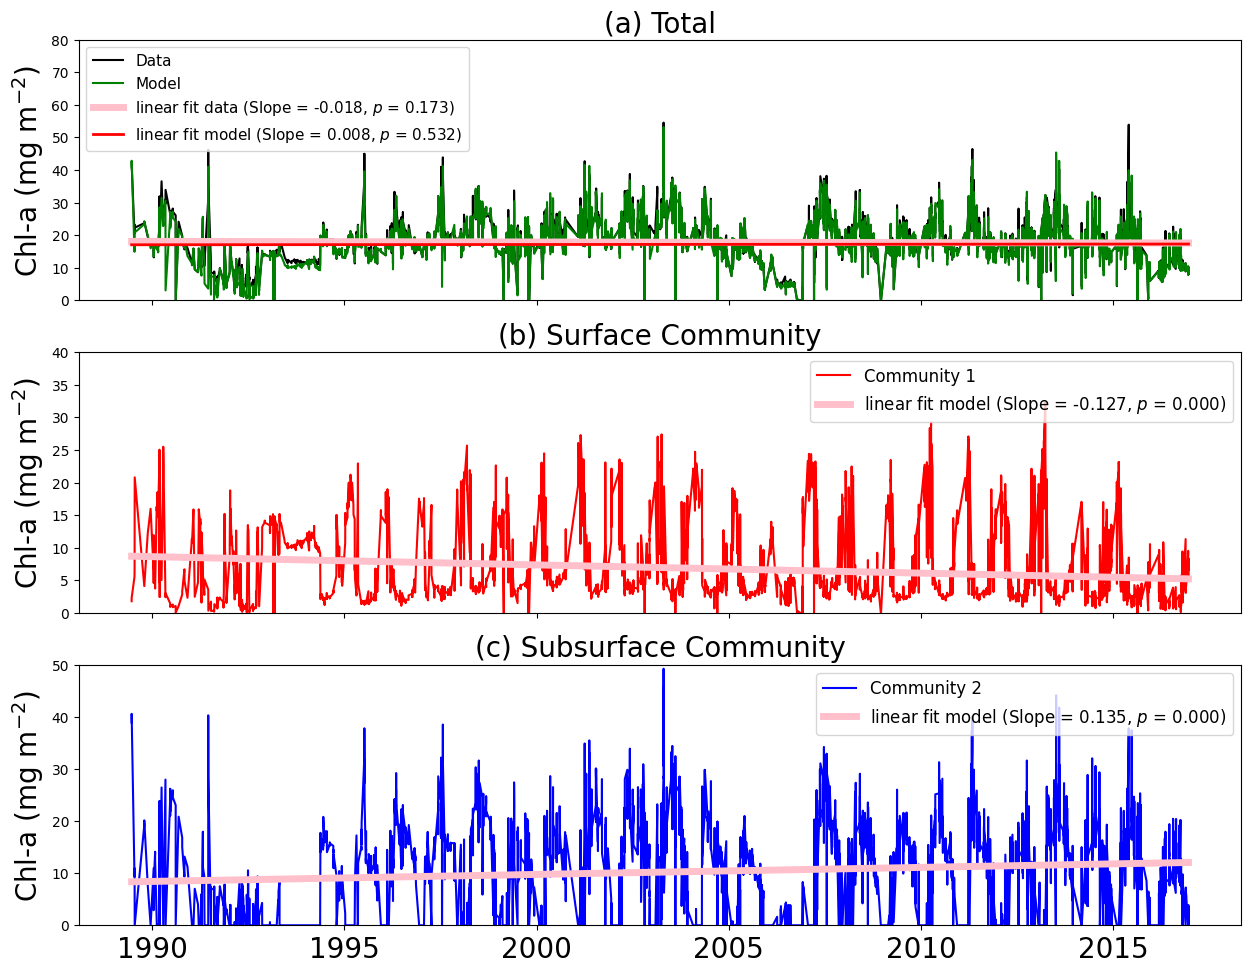

In [63]:
#Define the figure window including 5 subplots orientated vertically
XSIZE             = 15              #Define the xsize of the figure window
YSIZE             = 11.5            #Define the ysize of the figure window
titlesize         = 20
ylabsize          = 20
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(XSIZE,YSIZE), \
    gridspec_kw={'hspace': 0.2})
fig.patch.set_facecolor('White')
ax1.plot(Time_DEC_YEAR,raw_chl_data_int, label = 'Data', color = 'k')#, linewidth=1.0)
ax1.plot(Time_DEC_YEAR,Total_CHL_model_int, label = 'Model', color = 'g')
#remove nan
asd               = np.isfinite(raw_chl_data_int)
TIME2             = Time_DEC_YEAR[asd]
raw_chl_data_int2 = raw_chl_data_int[asd]
STATS_REG  = stats.pearsonr(TIME2, raw_chl_data_int2)
#pvalue
P_CORR_ST         = ("{0:.3f}".format(STATS_REG[1]))
raw_chl_data_int2 = np.array([raw_chl_data_int2]).reshape((-1, 1))
TIME2             = np.array([TIME2]).reshape((-1, 1))
model             = LinearRegression().fit(TIME2, raw_chl_data_int2)
print('1)')
print('intercept:', model.intercept_)
print ('R2',model.score(TIME2, raw_chl_data_int2),'adj R2',
       1 - (1-model.score(TIME2, raw_chl_data_int2))*(len(raw_chl_data_int2)-1)/(len(raw_chl_data_int2)-TIME2.shape[1]-1))
print('R2?',model.coef_)
print('r2',STATS_REG[0])
model2 = sm.OLS(TIME2, raw_chl_data_int2).fit()
print(model2.summary())
y_pred            = model.predict(TIME2)
#slope
slope = model.coef_
slope = slope[0]
slope = str("{0:.3f}".format(slope[0]))
ax1.plot(TIME2,y_pred, color = 'pink', label = 'linear fit data (Slope = '+slope+', $p$ = '+P_CORR_ST+')', linewidth=5.0)
#remove nan
asd               = np.isfinite(Total_CHL_model_int)
TIME2             = Time_DEC_YEAR[asd]
Total_CHL_model_int2 = Total_CHL_model_int[asd]
STATS_REG  = stats.pearsonr(TIME2, Total_CHL_model_int2)
#pvalue
P_CORR_ST         = ("{0:.3f}".format(STATS_REG[1]))
Total_CHL_model_int2 = np.array([Total_CHL_model_int2]).reshape((-1, 1))
TIME2             = np.array([TIME2]).reshape((-1, 1))
model             = LinearRegression().fit(TIME2, Total_CHL_model_int2)
print('2)')
print('intercept:', model.intercept_)
print ('R2',model.score(TIME2, Total_CHL_model_int2),
       'adj R2', 1 - (1-model.score(TIME2, Total_CHL_model_int2))*(len(Total_CHL_model_int2)-1)/(len(Total_CHL_model_int2)-TIME2.shape[1]-1))
print('R2?',model.coef_)
print('r2',STATS_REG[0])
model2 = sm.OLS(TIME2, Total_CHL_model_int2).fit()
print(model2.summary())
y_pred            = model.predict(TIME2)
#slope
slope = model.coef_
slope = slope[0]
slope = str("{0:.3f}".format(slope[0]))
ax1.plot(TIME2,y_pred, color = 'red', label = 'linear fit model (Slope = '+slope+', $p$ = '+P_CORR_ST+')', linewidth=2.0)
ax1.set_ylabel('Chl-a (mg m$^{-2}$)', fontsize= ylabsize, color='k')
ax1.set_title('(a) Total', fontsize= titlesize, color='k')
ax1.legend(loc="upper left", fontsize=11)
ax1.set_ylim([0, 80])

ax2.plot(Time_DEC_YEAR,surf_int, label = 'Community 1', color = 'red')
#remove nan
asd               = np.isfinite(surf_int)
TIME2             = Time_DEC_YEAR[asd]
surf_int2 = surf_int[asd]
STATS_REG  = stats.pearsonr(TIME2, surf_int2)
#pvalue
P_CORR_ST         = ("{0:.3f}".format(STATS_REG[1]))
surf_int2         = np.array([surf_int2]).reshape((-1, 1))
TIME2             = np.array([TIME2]).reshape((-1, 1))
model             = LinearRegression().fit(TIME2, surf_int2)
print('3)')
print('intercept:', model.intercept_)
print ('R2',model.score(TIME2, surf_int2),'adj R2', 1 - (1-model.score(TIME2, surf_int2))*(len(surf_int2)-1)/(len(surf_int2)-TIME2.shape[1]-1))
print('R2?',model.coef_)
print('r2',STATS_REG[0])
model2 = sm.OLS(TIME2, surf_int2).fit()
print(model2.summary())
y_pred            = model.predict(TIME2)
#slope
slope = model.coef_
slope = slope[0]
slope = str("{0:.3f}".format(slope[0]))
ax2.plot(TIME2,y_pred, color = 'pink', label = 'linear fit model (Slope = '+slope+', $p$ = '+P_CORR_ST+')', linewidth=5.0)
ax2.set_ylabel('Chl-a (mg m$^{-2}$)', fontsize= ylabsize, color='k')
ax2.set_title('(b) Surface Community', fontsize= titlesize, color='k')
ax2.legend(loc="upper right", fontsize=12)
ax2.set_ylim([0, 40])

ax3.plot(Time_DEC_YEAR,sub_int, label = 'Community 2', color = 'Blue')
#remove nan
asd               = np.isfinite(sub_int)
TIME2             = Time_DEC_YEAR[asd]
sub_int2 = sub_int[asd]
STATS_REG  = stats.pearsonr(TIME2, sub_int2)
#pvalue
P_CORR_ST         = ("{0:.3f}".format(STATS_REG[1]))
sub_int2          = np.array([sub_int2]).reshape((-1, 1))
TIME2             = np.array([TIME2]).reshape((-1, 1))
model             = LinearRegression().fit(TIME2, sub_int2)
print('4)')
print('intercept:', model.intercept_)
print ('R2',model.score(TIME2, sub_int2),'adj R2', 1 - (1-model.score(TIME2, sub_int2))*(len(sub_int2)-1)/(len(sub_int2)-TIME2.shape[1]-1))
print('Pearsons coeff, r2',STATS_REG[0])
print(STATS_REG)
model2 = sm.OLS(TIME2, sub_int2).fit()
print(model2.summary())
y_pred            = model.predict(TIME2)
#slope
slope = model.coef_
slope = slope[0]
slope = str("{0:.3f}".format(slope[0]))
ax3.plot(TIME2,y_pred, color = 'pink', label = 'linear fit model (Slope = '+slope+', $p$ = '+P_CORR_ST+')', linewidth=5.0)
ax3.set_ylabel('Chl-a (mg m$^{-2}$)', fontsize= ylabsize, color='k')
ax3.set_title('(c) Subsurface Community', fontsize= titlesize, color='k')
ax3.legend(loc="upper right", fontsize=12)
ax3.set_ylim([0, 50])
ax3.xaxis.set_tick_params(labelsize= ylabsize)##Add colourbar

plt.show()

In [64]:
# Enquiries for Dissertation write up
# 
# print(len(pd.read_csv('thousand_m_BATS.csv')))
# print(len(pd.read_csv('BATS_pigment.csv')))

print(len(TIME2), len(sub_int2))

4659 4659


In [1]:
# fig, (ax1) = plt.subplots(1, sharex=True, figsize=(12,9))
# xaxi = [1989.47,2016.95]
# ax1.set_ylim([250,0]) 
# ax1.set_xlim([xaxi[0],xaxi[-1]])
# ax1.plot(Decimal_year_2,MLD_2, color='k', linewidth=0.5)
# ax2=ax1.twinx()
# ax2.set_ylim([-20,50]) 
# ax2.plot(Time_DEC_YEAR,sub_int, label = 'Community 2', color = 'Blue')